In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#why are we using a modulo operator ever?
#what is role of gpe_bl and gpi_bl, will likely require reading...

In [14]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops=n_loops

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.zeros((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops)) * 0.05

        for i in range(30):
            self.a_inp[i+15] = [0.1,0.9,0.1]

        #variable to keep track of what step we are currently on
        self.c = 0




    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i, da):

        #likely easier to just define the parameters inside this function...
        
        dt = 0.001
        tau = 0.005
        #time constant 
        h= dt/tau

        #define the weight matrices
        w_inp_sp1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0.1
        w_inp_sp2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0.1
        w_inp_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0.0
        w_ctx_sp1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 0.4
        w_ctx_sp2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 3.2
        w_ctx_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 1
        w_sd1_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 3
        w_sd2_gpe = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 2
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 1
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 1
        w_gpe_stn = np.ones((self.n_loops,self.n_loops)) * 0.8
        w_gpe_gpi = np.ones((self.n_loops,self.n_loops)) * 0.3
        w_gpi_tha = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 3
        w_tha_ctx = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 4


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 0.5
        sd2_bl = 0.1
        sd2_DA = 20
        gpi_bl = 0.1
        gpe_bl = 0.1
        

        #input to sd1 from cortex modulated by dopamine, this completes the loop
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * da) * (np.matmul(self.a_ctx[i], w_ctx_sp1)+ np.matmul(self.a_inp[i], w_inp_sp1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * da)) * (np.matmul(self.a_ctx[i], w_ctx_sp2)) + (np.matmul(self.a_inp[i], w_inp_sp2)))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], w_ctx_stn)) - np.matmul(self.a_gpe[i], w_gpe_stn)) + (np.matmul(self.a_inp[i], w_inp_stn)) + gpe_bl)

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i]) - (np.matmul(self.a_sd2[i], w_sd2_gpe)) + (np.matmul(self.a_stn[i], w_stn_gpe)))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] - (np.matmul(self.a_sd1[i], w_sd1_gpi))   + (np.matmul(self.a_stn[i], w_stn_gpi)) - (np.matmul(self.a_gpe[i], w_gpe_gpi)) + gpi_bl))

        #input to gpi from 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_gpi[i], w_gpi_tha))))

        #input to cortex from gpi, also going to give some tonic excitation
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.a_tha[i], w_tha_ctx))))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(1*(vec)+0)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps):
        
        for i in range(steps):
            self.step(i=self.c,da=1)

    def display(self):
        
        plt.figure()
        plt.plot(self.a_inp,alpha=0.5)

        plt.figure()
        plt.plot(self.a_sd1,alpha=0.5)

        plt.figure()
        plt.plot(self.a_gpi,alpha=0.5)

        plt.figure()
        plt.plot(self.a_tha,alpha=0.5)

        plt.figure()
        plt.plot(self.a_ctx,alpha=0.5)

        return None



[[0.         0.         0.        ]
 [0.09966799 0.09966799 0.09966799]
 [0.07989575 0.07989575 0.07989575]
 [0.         0.         0.        ]
 [0.01562609 0.01562609 0.01562609]
 [0.10108921 0.10108921 0.10108921]
 [0.05822336 0.05822336 0.05822336]
 [0.         0.         0.        ]
 [0.04609234 0.04609234 0.04609234]
 [0.09434033 0.09434033 0.09434033]
 [0.01623458 0.01623458 0.01623458]
 [0.         0.         0.        ]
 [0.1026484  0.1026484  0.1026484 ]
 [0.08137737 0.08137737 0.08137737]
 [0.         0.         0.        ]
 [0.01449988 0.01449988 0.01449988]
 [0.10140943 0.10140943 0.10140943]
 [0.05977986 0.05977986 0.05977986]
 [0.         0.         0.        ]
 [0.04766351 0.04766351 0.04766351]
 [0.09407318 0.09370964 0.09407318]
 [0.01903669 0.01910937 0.01903669]
 [0.         0.         0.        ]
 [0.10106284 0.10076005 0.10106284]
 [0.08170702 0.08158734 0.08170702]
 [0.         0.         0.        ]
 [0.01761397 0.01730711 0.01761397]
 [0.10073323 0.10061582 0.10

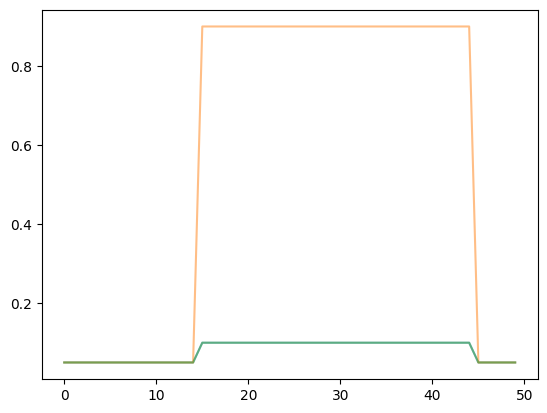

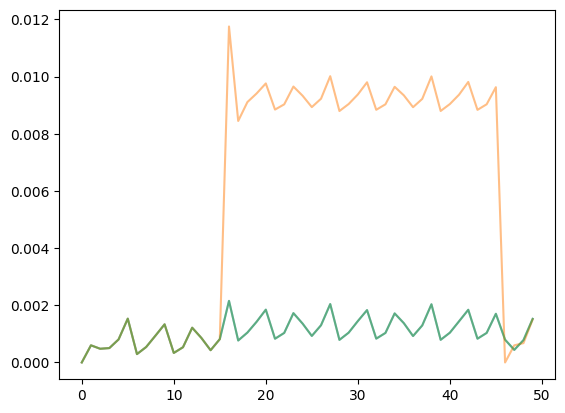

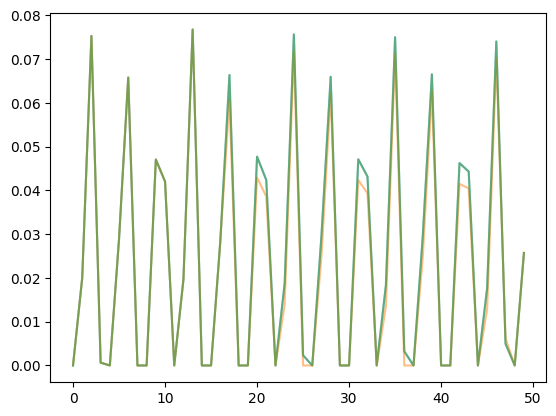

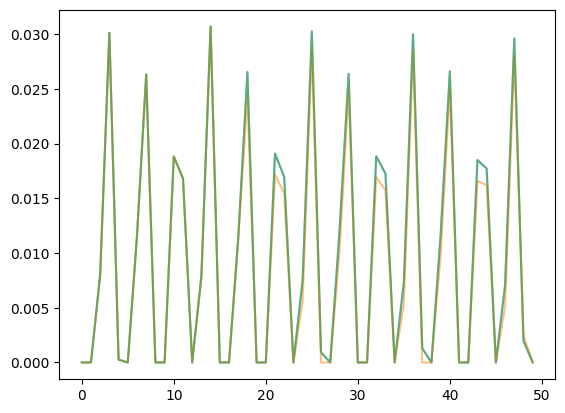

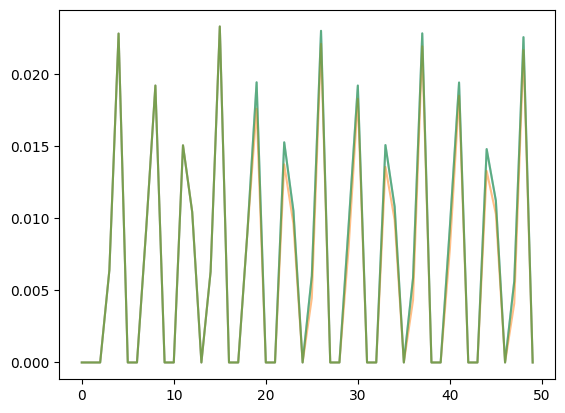

In [15]:
bg = b_ganglia(3,50)

bg.run(49)
print(bg.a_stn)
bg.display()


